In [48]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from ipywidgets import interact

In [38]:
def lire_alpha_digit(digits, chars):
    """
    Takes as input alpha_digits and an array 'chars' containing the letters or integers to select from the alpha_digits
    """
    indexes = []
    for chr in chars:
        # check if positive integer
        if (chr.isdigit() and int(chr)<10 and int(chr)>0):
            indexes.append(int(chr))
        # check if letter
        elif(chr.isalpha() and len(chr)==1):
            indexes.append(ord(chr.lower()) - 87)
    return digits[indexes, :]

In [54]:
digits = scipy.io.loadmat('binaryalphadigs.mat')['dat']

selected_digits = lire_alpha_digit(digits, ['3', '7', 'A', '-5', 'cb', 'X']) # -5 and 'cb' won't be taken into consideration

def plot_chars(chars=0):
    plt.imshow(selected_digits[chars][15])
    plt.show()
interact(plot_chars, chars=(0,selected_digits.shape[0]-1))

interactive(children=(IntSlider(value=0, description='chars', max=3), Output()), _dom_classes=('widget-interac…

<function __main__.plot_chars(chars=0)>

A file named 'MNIST' in the same directory should contain the training and testing files extracted, and renamed by replacing the '.' to a '-' <br>
(ex: t10k-images.idx3-ubyte -> t10k-images-idx3-ubyte)

In [40]:
mndata = MNIST('MNIST')
X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], 28, 28)
y_train = np.array(y_train)

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], 28, 28)
y_test = np.array(y_test)

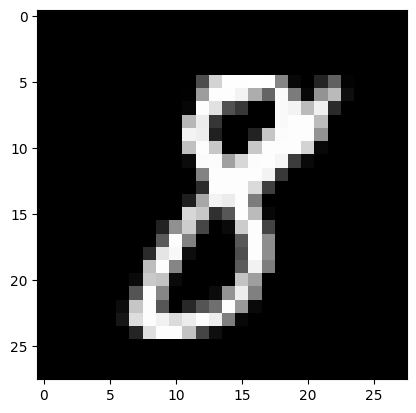

In [41]:
plt.imshow(X_train[85], cmap='gray')
plt.show()

In [42]:
def black_white(X, threshold = 125):
    """
    Convert grayscale images of input X to black-and-white images based on given threshold.
    """
    XX = np.empty_like(X)
    XX[X< threshold] = 0
    XX[X>=threshold] = 1
    XX = XX.reshape(*XX.shape, 1) 
    return XX

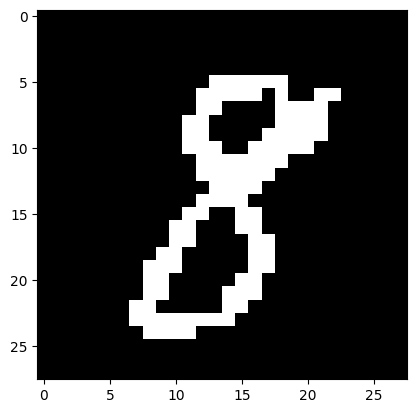

In [43]:
X_train_new = black_white(X_train)

plt.imshow(X_train_new[85], cmap='gray')
plt.show()

In [44]:
def init_RBM(in_shape, out_shape, var=0.1):
    """
    Initialize an RBM structure with biases set to zeros and weights following a centered normal distribution.
    """
    a = np.zeros(in_shape)
    b = np.zeros(out_shape)
    W = np.random.normal(0, var, (in_shape, out_shape))
    return a, b, W

a, b, W = init_RBM(5, 6)

In [45]:
def sigmoid(x):
    return 1/(1+np.exp(x))

class RBM:
    def __init__(self, in_shape, out_shape, W=None, a=None, b=None, var=0.1):
        assert in_shape != 0 and out_shape != 0
        self.in_shape = in_shape
        self.out_shape = out_shape
        
        self.a = a if a is not None else np.zeros(in_shape)
        self.b = b if b is not None else np.zeros(out_shape)
        self.W = W if W is not None else np.random.normal(0, var, (in_shape, out_shape))
        assert self.W.shape == (in_shape, out_shape) and (self.a).shape[0] == in_shape and (self.b).shape[0] == out_shape
        return
    
    def entree_sortie_RBM(self, X_input):
        prod = np.dot(X_input, self.W) + self.b
        assert prod.shape == (X_input.shape[0], self.out_shape)
        sig = sigmoid(prod)
        return np.random.binomial(1, sig, prod.shape)
    
    def sortie_entree_RBM(self, X_output):
        prod = np.dot(X_output, self.W.T) + self.a
        assert prod.shape == (X_output.shape[0], self.in_shape)
        sig = sigmoid(prod)
        return np.random.binomial(1, sig, prod.shape)


In [46]:
my_rbm = RBM(7, 4)

# Testing entree_sortie_RBM
in_try = np.random.randint(low=0, high=255, size = (8,7))
my_rbm.entree_sortie_RBM(in_try)


array([[0, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 0, 1]])

In [47]:
# Testing sortie_entree_RBM
out_try = np.random.randint(low=0, high=255, size = (8,4))
my_rbm.sortie_entree_RBM(out_try)

array([[0, 1, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 0, 1]])